In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### data link: https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
df_housing = pd.read_csv("housing.csv")
print(len(df_housing))
df_housing.head()

20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data preparation

In [3]:
df_housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [4]:
df_housing['ocean_proximity'] = df_housing['ocean_proximity'].str.lower().str.replace(' ','_')

## Exploratory analysis
Load the data.
Look at the median_house_value variable. Does it have a long tail?

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

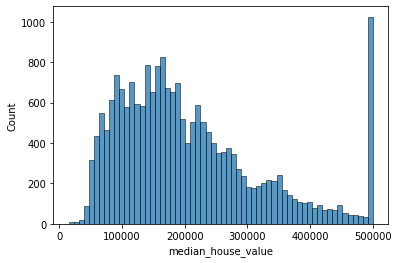

In [5]:
sns.histplot(df_housing.median_house_value, bins=60)

In [6]:
price_logs = np.log1p(df_housing.median_house_value)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

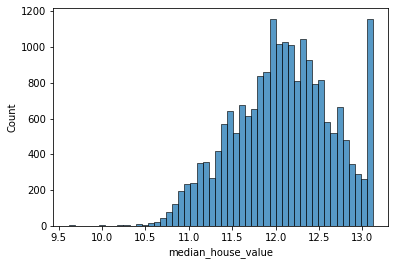

In [7]:
sns.histplot(price_logs, bins=50)

In [8]:
features = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income',
           'median_house_value']

### Question 1
Find a feature with missing values. How many missing values does it have?

In [9]:
df_housing[features].isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2
What's the median (50% percentile) for variable 'population'?

In [10]:
df_housing['population'].median()

1166.0

### Split the data
Shuffle the initial dataset, use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Make sure that the target value ('median_house_value') is not in your dataframe.
Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [11]:
n = len(df_housing)

#length of train, val and test
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [12]:
idx

array([20046,  3024, 15663, ...,  5390,   860, 15795])

In [13]:
df_housing = df_housing[features]
df_train = df_housing.iloc[idx[:n_train]]
df_val = df_housing.iloc[idx[n_train:n_train+n_val]]
df_test = df_housing.iloc[idx[n_train+n_val:]]

In [14]:
df_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
20046,36.06,-119.01,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0
3024,35.14,-119.46,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0
15663,37.80,-122.44,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0
20484,34.28,-118.72,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0
9814,36.62,-121.93,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0


In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [17]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3
We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE? 

In [18]:
def prepare_X(df,replace_with):
    df = df.copy()
    
    #fill nulls
    df.total_bedrooms = df.total_bedrooms.fillna(replace_with)
    X = df.values

    return X

In [19]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [20]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    score = np.sqrt(mse)
    return round(score,2)

#### 1. fill nulls with 0

In [21]:
X_train = prepare_X(df_train,0)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val,0)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.33

#### 2. fill nulls with mean

In [22]:
df_train.total_bedrooms.describe()


count    12177.000000
mean       533.480332
std        422.223754
min          2.000000
25%        295.000000
50%        431.000000
75%        641.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [23]:
_mean = df_train.total_bedrooms.mean()
X_train = prepare_X(df_train,_mean)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val,_mean)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.33

#### 3. fill nulls with median

In [24]:
_median = df_train.total_bedrooms.median()
X_train = prepare_X(df_train,_median)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val,_median)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.33

### Question 4
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

In [25]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [26]:
rmse_vals = []
reg_vals = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for r in reg_vals:
    X_train = prepare_X(df_train,0)
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val,0)
    y_pred = w0 + X_val.dot(w)
    rmse_vals.append(rmse(y_val, y_pred))


In [27]:
rmse_vals

[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.34, 0.34]

In [28]:
idx = [i for i,val in enumerate(rmse_vals) if val==min(rmse_vals)]
min_r = [reg_vals[i] for i in idx ]
min(min_r)

0

### Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))

In [29]:
#function to do the split
def split_data(df,seed_val):
    df_copy = df.copy()
    n = len(df)

    #length of train, val and test
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seed_val)
    np.random.shuffle(idx)

    features = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income',
           'median_house_value']
    df_copy = df_copy[features]
    df_train = df_copy.iloc[idx[:n_train]]
    df_val = df_copy.iloc[idx[n_train:n_train+n_val]]
    df_test = df_copy.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    return df_train,df_val,df_test,y_train,y_val,y_test

In [30]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_vals = []
for seed in seeds:
    df_train,df_val,df_test,y_train,y_val,y_test = split_data(df_housing,seed)
    X_train = prepare_X(df_train,0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val,0)
    y_pred = w0 + X_val.dot(w)
    rmse_vals.append(rmse(y_val, y_pred))
rmse_vals

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [31]:
std = np.std(rmse_vals)
round(std,3)

0.005

### Question 6
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [32]:
df_train,df_val,df_test,y_train,y_val,y_test = split_data(df_housing,9)
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train,0)
y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, 0.001)

X_test = prepare_X(df_test,0)
y_pred = w0 + X_test.dot(w)
type(y_test),type(y_pred)
score = rmse(y_test, y_pred)
score

0.35